# Structural estimation of dynamic models

“Dynamic programming and structural estimation” mini course

Fedor Iskhakov

## Self-written module from the disk

The **deaton.py** is the module that has the code from previous lecture that implements the Deaton model

In [1]:
# import deaton.py module
import sys
sys.path.insert(1, './')
from deaton import *
%matplotlib inline

## Simulating from the model

- When the policy function (optional consumption rule) $ c^\star(M) $ is computed and plugged into the Bellman equation, we have a dynamic model *(similar to the inventory or wealth dynamics, see day 3)*  
- Given any initial distribution of wealth, we can simulate it in any number periods under the optimal consumption/savings behavior  
- We can also study dynamics of wealth distribution implied by the optimal consumption/savings behavior  

### Simulation algorithm

1. Draw initial wealth (initial conditions)  
1. Apply the policy function  
1. Compute the next period wealth (including random transitions if present)  
1. Repeat from step 2 for the chosen number of periods  

### Introduce random element into the model

- Let income $ y $ be drawn from log-normal distributions in each time period  
- Simulate the behavior of the agents in this environment using our solution of the consumption-savings model  


*What behavior assumptions are we making implicitly?*

In [2]:
def simulator(model, policy, init=[1], T=100, sigma_y=0.,plot=True):
    '''Simulator for T periods of the model, init = initial wealth'''
    assert isinstance(model,deaton), 'Need Deaton model as first input'
    # prepare the interpolation for the solution
    inter = interpolate.interp1d(model.grid_state,policy,fill_value="extrapolate")
    # prepare the initial conditions
    init = np.array(init).flatten()
    N = init.size # number of individuals to simulate
    sim = {'M': np.empty((N,T),dtype='float'),
           'c': np.empty((N,T),dtype='float'),
           'y': np.empty((N,T),dtype='float'),}
    # initialize wealth in first period
    sim['M'][:,0] = init
    sim['y'][:,0] = np.full(init.shape,np.nan)
    for t in range(T):
        sim['c'][:,t] = inter(sim['M'][:,t]) # optim consumption
        if t < T-1: # until the last period
            y = np.exp(sigma_y * np.random.randn(N)) # draw incomes
            sim['y'][:,t+1] = y
            sim['M'][:,t+1] = model.R*(sim['M'][:,t]-sim['c'][:,t]) + y # compute next period wealth
    if plot:
        fig, ax = plt.subplots(1,1,figsize=(10,8))
        ax.plot(np.transpose(sim['M']))
        ax.set_title('Simulated wealth paths');
        plt.show()
    return sim

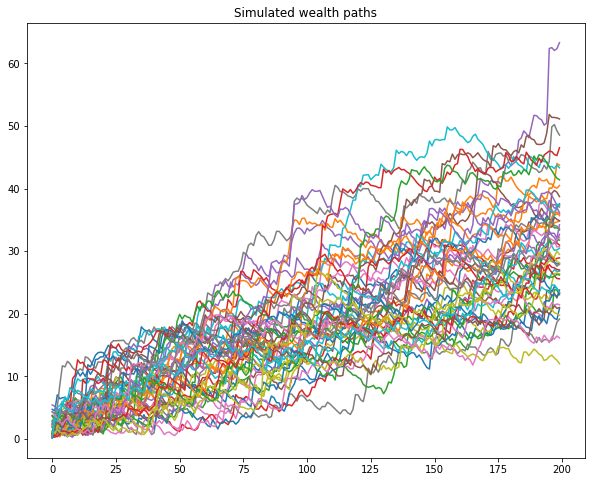

In [3]:
model = deaton(beta=0.95,y=1,Mbar=30,ngrid_state=50,ngrid_choice=150)
V,policy = model.solve_egm(maxiter=500)
# V,policy = model.solve_vfi(maxiter=500)
np.random.seed(14) # fix seed for initial draws
init_wealth = np.exp(np.random.randn(50)) # draw initial wealth
np.random.seed(15) # fix seed for simulations
d=simulator(model,policy,init=init_wealth,sigma_y=.65,T=200)

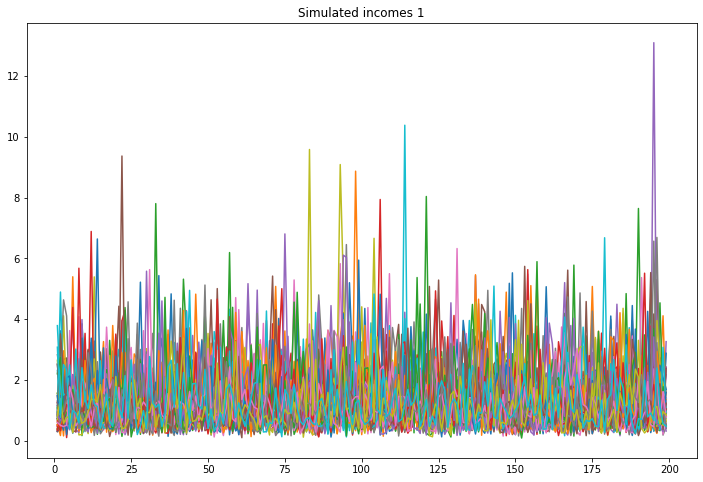

In [4]:
# draw simulated inomes
fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(np.transpose(d['y']))
ax1.set_title('Simulated incomes 1');
plt.show()

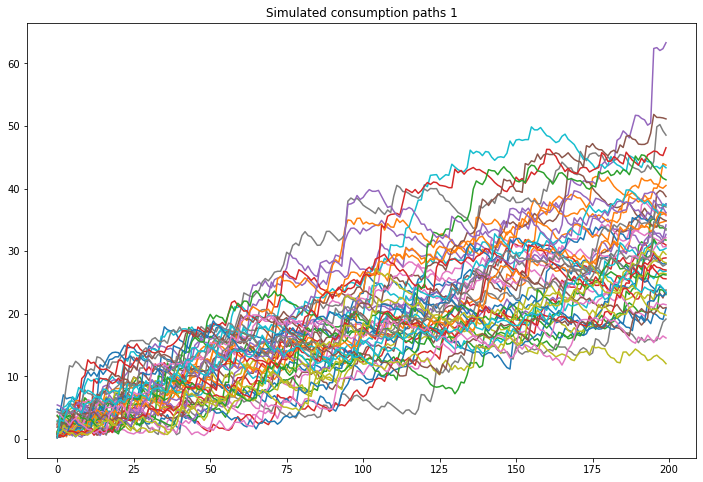

In [5]:
# draw simulated consumption
fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(np.transpose(d['M']))
ax1.set_title('Simulated consumption paths 1');
plt.show()

## Structural estimation

Changing parameters of the model is reflected in changes in the simulated profiles.

Imagine we have data on observed consumption or wealth profiles for a sample of people.

Can find parameters of the model that would induce the simulated data to reflect the observed data in the best possible way.

### Method of simulated moments

The idea of *directly* matching simulated data to the observed one leads to the method of moments estimator

- Method of moments: # of parameters = # of moments to match, system of equations  
- Generalized method of moments (GMM): # of parameters < # of moments, minimize the distance between the data moments and theoretical moments  
- Method of simulated moments (MSM): using simulations to compute the theoretical moments  

### MSM properties

MSM is very flexible in applications:

- not data hungry (may match aggregated moments)  
- allows to combine different sources of data  
- does not require complete specification for random variables  
- lacks in efficiency, so standard errors are larger (depend on sample size)  

### Sources of identification

Parameters are identified from both

1. the variation of the observed data  
1. modeling assumptions such as **exclusion restrictions**, **functional forms** and **distributional assumptions**  


This is true for both *reduced form* econometrics and *structural econometrics*,
although the former usually emphasizes low number of assumptions and low importance of 2.

### Structural vs. reduced form econometrics

Compared to reduced form, structural econometrics is very explicit of the assumptions
in the model (and is often criticized for excessive number or unreasonable assumptions)

But it uses **economic theory** to formulate the assumptions, and is able to leverage theoretical knowledge for making predictions

### Counterfactual simulations

1. Estimate the model using observed data  
1. Verify the model (highly desirable step, not always possible)  
1. Simulate data under status quo  
1. Change the policy environment, while deep behavioral parameters are unaffected  
1. Simulate data under alternative regime  
1. Compare to reveal the effects of the policy  

### MSM estimator

**Algorithm**

1. Choose the set of statistics (moments) to match  
  - Choosing which moments to match is more art than science  
  - Requirement: have to lead to identification of parameters  
  - Economic intuition  
1. For a given set of structural parameters:  
1. Solve the model  
1. Simulated data from the model  
1. Compute model conditions = differences between the  

### Standard errors of estimates

- Each estimation method produces measure of accuracy of the computed estimates  
- Idea: this is reflected in the flatness of the criterion function at the optimum  
- Theoretical foundation in asymptotic theory, standard in econometrics  
- Not hard to compute, apart from degenerate cases  
- Is also a numerical diagnostic tool for potential problems with the model, such as identification  

### Definition of MSM estimator

$$
\hat{\theta}_{MSM} = \arg\min_{\theta} e(\tilde{x},x|\theta)^{T} W e(\tilde{x},x|\theta)
$$

$ x $ and $ \tilde{x} $ is observed and simulated data,

$ e(\tilde{x},x|\theta) $ is the difference between observed and simulated moments

$$
e(\tilde{x},x|\theta) = m(x) - m(\tilde{x}|\theta),
$$

$ W $ is weighting matrix (important for the efficiency of the estimator)

### Estimation exercise

- Structural parameter: is discount factor $ \beta $ (true value 0.91)  
- Moments to match: mean and standard deviation of the (stationary) wealth distribution  
- Use simplest identity weighting matrix $ W $ for now  
  - In reality it would make sense to weight down the moments which are poorly measured in the data  
  - There is a theory of what the optimal weighting matrix should be, but in practice a simpler approximations are usually used  
- Income is drawn from log-normal distribution with $ sigma_y=0.65 $, but agents are myopic about income uncertainty  

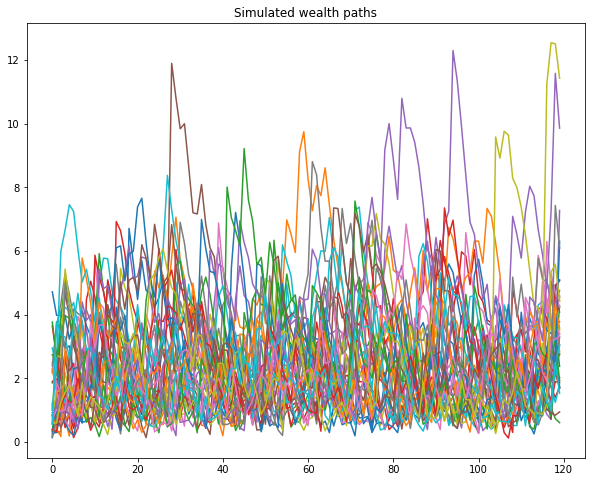

In [6]:
# Simulate DATA using true parameters
model = deaton(beta=0.91,y=1,Mbar=30,ngrid_state=50,ngrid_choice=50)
[],dgp = model.solve_egm()
np.random.seed(14) # fix seed for initial draws
init_wealth = np.exp(np.random.randn(40)) # draw initial wealth
np.random.seed(15) # fix seed for simulations
data = simulator(model,dgp,init=init_wealth,T=120,sigma_y=.65)

In [7]:
# Data moments
print('Number of observed individuals: ',data['M'].shape[0],sep=' ')
print('Number of observed time periods:',data['M'].shape[1],sep=' ')
data_mean = np.mean(data['M'][:,-10:])
data_std = np.std(data['M'][:,-10:])
print('Mean wealth (pooled over last 10 simulated time periods):  ',data_mean,sep=' ')
print('Std of wealth (pooled over last 10 simulated time periods):',data_std,sep=' ')

Number of observed individuals:  40
Number of observed time periods: 120
Mean wealth (pooled over last 10 simulated time periods):   2.7972296340420018
Std of wealth (pooled over last 10 simulated time periods): 1.8300668738606667


In [8]:
# MSM estimation exercise
model = deaton(beta=0.95,y=1,Mbar=30,ngrid_state=100,ngrid_choice=250)
np.random.seed(214) # different seed from DGP
init_wealth = np.exp(np.random.randn(150)) # draw initial wealth
W = np.eye(2) #weighting matrix

def moment_conditions(beta):
    '''Moment conditions for MSM estimator'''
    model.beta = beta
    np.random.seed(215) # must be fixed between calls!
    v,p = model.solve_vfi(maxiter=1000)
    simdata = simulator(model,p,init=init_wealth,T=125,sigma_y=.65,plot=False)
    #compute simulated moments
    simdata_mean = np.mean(simdata['M'][:,-10:])
    simdata_std = np.std(simdata['M'][:,-10:])
    err = np.array([data_mean-simdata_mean, data_std-simdata_std])
    return err

def criterion(beta):
    '''Criterion function for MSM estimator'''
    err = moment_conditions(beta)
    return err @ W @ err.T #matrix multiplication

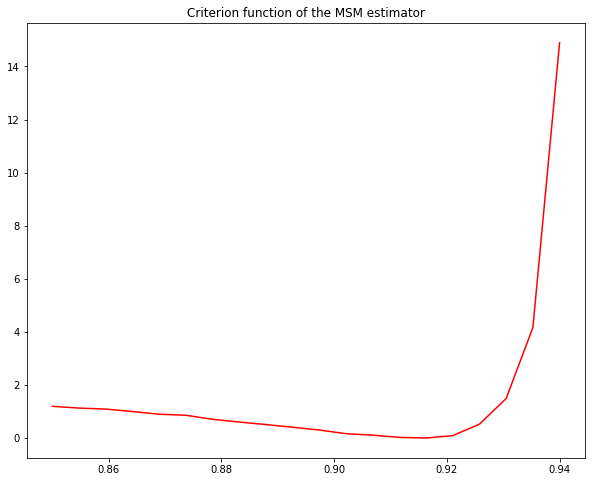

In [9]:
# Plot criterion for visual inspection
xd = np.linspace(.85,.94,20)
yd = [criterion(b) for b in xd]
plt.figure(num=1, figsize=(10,8))
plt.plot(xd,yd,color='r')
plt.title('Criterion function of the MSM estimator');

In [10]:
# Run numerical optimization
from scipy.optimize import minimize_scalar

res = minimize_scalar(criterion,
                      method='Bounded',
                      bounds=[.85,.95],
                      options={'maxiter':100, 'xatol':1e-8},
                      )
if res.success:
    print('Converged successfully!')
    print(res)
    beta_hat = res.x
else:
    print('Failed to converge')

Converged successfully!
     fun: 0.0031751053161266016
 message: 'Solution found.'
    nfev: 27
  status: 0
 success: True
       x: 0.9151011383749508


### Calculating the variance-covariance matrix for the estimates

Daniel McFadden. A method of simulated moments for estimation of discrete response models without numerical integration. Econometrica, 1989 (pages 995–1026)

Ariel Pakes and David Pollard. Simulation and the Asymptotics of Optimization Estimators. Econometrica, 1989 (pp. 1027-1057)

- The asymptotic theory is well established, but full expressions are cumbersome  
- When weighting matrix $ W $ is identity matrix, the variance-covariance matrix of the estimates is given by  


$$
\hat{\Sigma} = (1-N/\tilde{N}) \big(D' D \big)^{-1},
$$

$ N $ and $ \tilde{N} $ are number of observations and number of simulations

$ D $ is the Jacobian of the moment conditions $ e(\tilde{x},x|\theta) $ with respect to $ \theta $ computed at a consistent estimator

In [11]:
# Compute numerical derivatives of the moment conditions
h = 1e-4
f0 = moment_conditions(beta_hat)
f1 = moment_conditions(beta_hat-h)
D = (f0-f1)/h
N = data['M'].shape[0]
Nt = init_wealth.size
Sigma = (1-N/Nt)/(np.dot(D,D))
beta_std = np.sqrt(Sigma)
#Main output:
print('Final estimate is ',beta_hat,' (',beta_std,')')

Final estimate is  0.9151011383749508  ( 0.0019301055269819942 )


### This is only a primer to MSM

To complete MSM:

- more accurate weighting matrix  
- iterative procedure to recompute the weighting matrix using the current consistent (but not efficient) MSM estimator  
- better founded choice of moments to match  
- identification analysis (including manual simulations)  
- obvious extension to multiple structural parameters  